# Samtools stats

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/nfcore_sarek_rerun")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")

In [2]:
def grep_file(file, key, columns=None):
    data = []
    with open(file) as f:
        for line in f:
            if line.startswith(key):
                data.append(line.strip().split("\t")[1:])

    if columns:
        data = pd.DataFrame(data, columns=columns)
    else: 
        data = pd.DataFrame(data)
    return data

def files(suffix):
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2", "REH"]

    for run in runs:
        for cell in cells:
            file = basedir / f"{run}/outdir/reports/samtools/{cell}/{cell}{suffix}"
            yield run, cell, file

def files_md():
    yield from files(suffix=".md.cram.stats")

def files_recal():
    yield from files(suffix=".recal.cram.stats")


## Insert sizes

In [3]:
ins = [] 
columns = ["size", "total pairs", "inward oriented pairs", "outward orient pairs", "other orientation pairs"]
for run, cell, file in files_md():
    d = grep_file(file, "IS", columns)
    d = d.astype({c: int for c in columns})
    d["run"] = run
    d["Cell line"] = cell

    # Filter shortest inserts
    d = d[d["size"] > 20]
    # Normalize
    d["% of pairs"] = 100 * d["total pairs"] / d["total pairs"].sum()
    d["total_bases"] = 100 * d["total pairs"] * d["size"] 
    d["% of bases"] = 100 * d["total_bases"] / d["total_bases"].sum()
    d["cumula_bases"] = np.cumsum(d["% of bases"])
    d["cumula_pairs"] = np.cumsum(d["% of bases"])
    ins.append(d)

ins = pd.concat(ins).reset_index()
ins["Data source"] = ins["run"].replace(run_names)  

ins["% out"] = 100 * ins["outward orient pairs"] / ins["total pairs"]
ins["% in"] = 100 * ins["inward oriented pairs"] / ins["total pairs"]
ins["% other"] = 100 * ins["other orientation pairs"] / ins["total pairs"]
ins.head()

,index,size,total pairs,inward oriented pairs,outward orient pairs,other orientation pairs,run,Cell line,% of pairs,total_bases,% of bases,cumula_bases,cumula_pairs,Data source,% out,% in,% other
0,21,21,3282,345,2918,19,aviti_ngi,KMS12BM,0.001761,6892200,0.000094,0.000094,0.000094,AVITI CB FS,88.909202,10.511883,0.578915
1,22,22,2937,315,2610,12,aviti_ngi,KMS12BM,0.001576,6461400,0.000088,0.000183,0.000183,AVITI CB FS,88.866190,10.725230,0.408580
2,23,23,2737,170,2553,14,aviti_ngi,KMS12BM,0.001469,6295100,0.000086,0.000269,0.000269,AVITI CB FS,93.277311,6.211180,0.511509
3,24,24,2532,76,2445,11,aviti_ngi,KMS12BM,0.001359,6076800,0.000083,0.000352,0.000352,AVITI CB FS,96.563981,3.001580,0.434439
4,25,25,2530,63,2455,12,aviti_ngi,KMS12BM,0.001358,6325000,0.000087,0.000439,0.000439,AVITI CB FS,97.035573,2.490119,0.474308


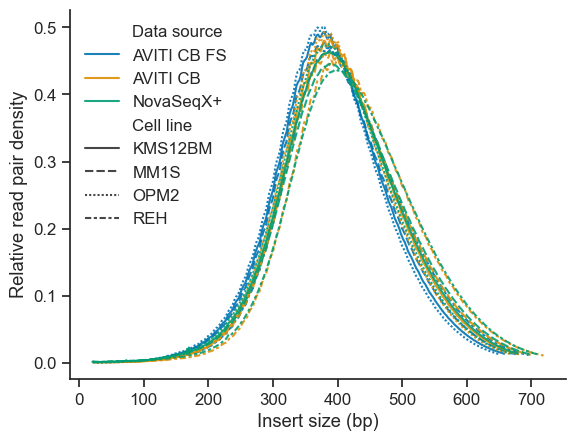

In [4]:
ax = sns.lineplot(data=ins, x="size", y="% of pairs", hue="Data source", style="Cell line", hue_order=run_names.values(), alpha=0.9)
ax.set_xlabel("Insert size (bp)")
ax.set_ylabel("Relative read pair density")
sns.move_legend(ax, "upper left", bbox_to_anchor=(0, 1))
plt.legend(frameon=False, framealpha=0)

fig = ax.get_figure()
fig.savefig(figdir / "insert_size_vs_reads_density.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')

### Mean and median size

In [5]:
ins_agg = []
for group, d in ins.groupby(["Data source", "Cell line"]):
    mean = (d["size"] * d["total pairs"]).sum() / d["total pairs"].sum()
    d = d.sort_values(by="size")
    median = d["size"][np.cumsum(d["total pairs"]) > d["total pairs"].sum()/2].values[0]
    #print(*group, median, mean, sep="\t")
    ins_agg.append((*group, median, mean))

ins_agg = pd.DataFrame(ins_agg, columns=["Data source", "Cell line", "Mean", "Median"])
ins_agg

,Data source,Cell line,Mean,Median
0,AVITI CB,KMS12BM,401,406.074291
1,AVITI CB,MM1S,405,411.338014
2,AVITI CB,OPM2,396,400.179568
3,AVITI CB,REH,419,425.640384
4,AVITI CB FS,KMS12BM,388,392.255178
5,AVITI CB FS,MM1S,393,397.657927
6,AVITI CB FS,OPM2,384,387.318217
7,AVITI CB FS,REH,405,410.642257
8,NovaSeqX+,KMS12BM,401,405.916497
9,NovaSeqX+,MM1S,407,411.970898


## Reported base quality

In [6]:
bq = [] 

for run, cell, file in files_md():
    d1 = grep_file(file, "FFQ")
    d1 = d1.astype({c: int for c in d1.columns})
    d2 = grep_file(file, "LFQ")
    d2 = d2.astype({c: int for c in d2.columns})
    d2[0] += d1[0].max()
    d = pd.concat([d1,d2])
    quals = list(range(0,d.shape[1]-1))
    columns = ["cycle"] + quals
    d.columns = columns
    bases = d[quals].sum(axis=0).values
    norm = bases / bases.sum()
    cumsum = [100] + list(100 * (1 - np.cumsum(norm)))
    
    bq.append(pd.DataFrame({
        "run": run,
        "Cell line": cell,
        "quals": quals,
        "bases": bases,
        "norm": norm,
        "cumsum": cumsum[:-1],
    }))
    
bq = pd.concat(bq).reset_index(drop=True)
bq["Data source"] = bq["run"].replace(run_names)
bq.head()

,run,Cell line,quals,bases,norm,cumsum,Data source
0,aviti_ngi,KMS12BM,0,8568562,1.502126e-04,100.000000,AVITI CB FS
1,aviti_ngi,KMS12BM,1,19849,3.479662e-07,99.984979,AVITI CB FS
2,aviti_ngi,KMS12BM,2,1652262,2.896525e-05,99.984944,AVITI CB FS
3,aviti_ngi,KMS12BM,3,29283393,5.133573e-04,99.982047,AVITI CB FS
4,aviti_ngi,KMS12BM,4,38503386,6.749899e-04,99.930712,AVITI CB FS


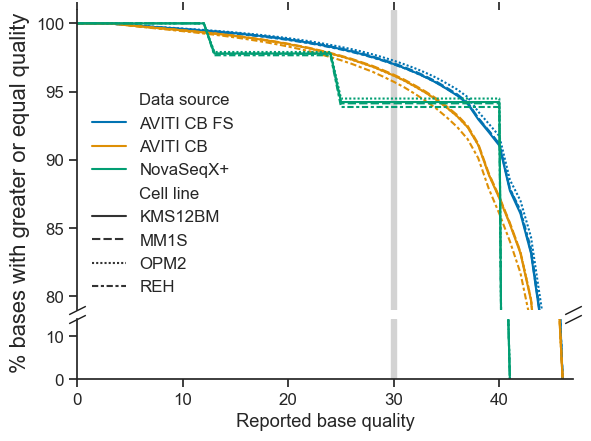

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, height_ratios=[5,1])
fig.subplots_adjust(hspace=0.05)  # adjust space between Axes
ax1.axvspan(29.75, 30.25, color="lightgrey")
ax2.axvspan(29.75, 30.25, color="lightgrey")

ax1 = sns.lineplot(bq, x="quals", y="cumsum", hue="Data source", style="Cell line", hue_order=run_names.values(), ax=ax1)
_ = ax1.set(xlabel="Reported base quality", ylabel="",
       xlim=(0,bq["quals"].max()+1))
fig.supylabel("% bases with greater or equal quality")
ax1.legend(frameon=False, framealpha=0)

sns.move_legend(ax1, bbox_to_anchor=(0,0), loc="lower left")

ax2 = sns.lineplot(bq, x="quals", y="cumsum", hue="Data source", style="Cell line", hue_order=run_names.values(), ax=ax2, legend=False)
_ = ax2.set(xlabel="Reported base quality", ylabel="", 
       xlim=(0,bq["quals"].max()+1))

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(79, 101)  # outliers only
ax2.set_ylim(0, 14)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Now, let's turn towards the cut-out slanted lines.
# We create line objects in axes coordinates, in which (0,0), (0,1),
# (1,0), and (1,1) are the four corners of the Axes.
# The slanted lines themselves are markers at those locations, such that the
# lines keep their angle and position, independent of the Axes size or scale
# Finally, we need to disable clipping.

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

fig.savefig(figdir / "reported_base_quality_cumulative_density.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')

### Bases >= Q30 and >Q40

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_69396/1397207901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["cumsum"] = d["cumsum"]


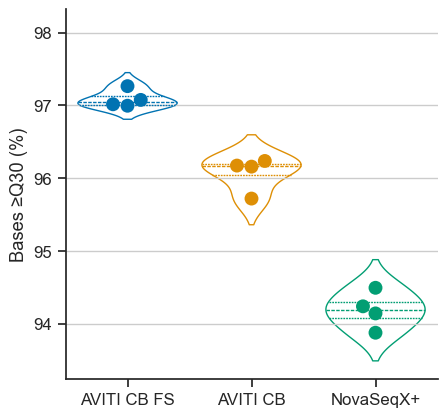

In [8]:

d = bq[bq["quals"] == 30]
d["cumsum"] = d["cumsum"] 
fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax = sns.swarmplot(d, y="cumsum", ax=ax, x="Data source", s=10,
                 hue="Data source", order=run_names.values())
ax = sns.violinplot(d, y="cumsum", ax=ax, x="Data source", order=run_names.values(),
                 hue="Data source", hue_order=run_names.values(), fill=False,
                 inner="quartile", linewidth=1, zorder=-1)
ymin = d["cumsum"].mean() - 2 * d["cumsum"].std()
ymax = d["cumsum"].mean() + 2 * d["cumsum"].std()
ax.set_ylim(ymin, ymax)
ax.set_ylabel("Bases ≥Q30 (%)")
ax.set_xlabel("")
ax.grid(True, axis="y")
fig = ax.get_figure()
fig.savefig(figdir / "reported_base_quality_geQ30_violin.svg", backend='svg', 
            transparent=True, dpi=300, bbox_inches='tight')

In [9]:
d = bq[bq["quals"] == 30].groupby(["Data source"]).agg({"cumsum": ["min", "max"]}).reset_index()
d.apply(lambda x: round(x,1))

Data source cumsum      
                  min   max
0     AVITI CB   95.7  96.2
1  AVITI CB FS   97.0  97.3
2    NovaSeqX+   93.9  94.5

In [10]:
d = bq[bq["quals"] == 41].groupby(["Data source"]).agg({"cumsum": ["min", "max"]}).reset_index()
d.apply(lambda x: round(x,1))

Data source cumsum      
                  min   max
0     AVITI CB   84.0  85.4
1  AVITI CB FS   87.7  88.5
2    NovaSeqX+    0.0   0.0

### Binning Element qualities
https://knowledge.illumina.com/instrumentation/novaseq-x-x-plus/instrumentation-novaseq-x-x-plus-reference_material-list/000008320 

Bin

Q Score Range
0: 0-2
12: 3-17
24: 18-29
40: 30+

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_69396/3719055102.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = d.groupby(["Data source", "Cell line", "qbin"],as_index=False).agg({"bases":"sum", "norm": "sum"})


(0.9, 1.0)

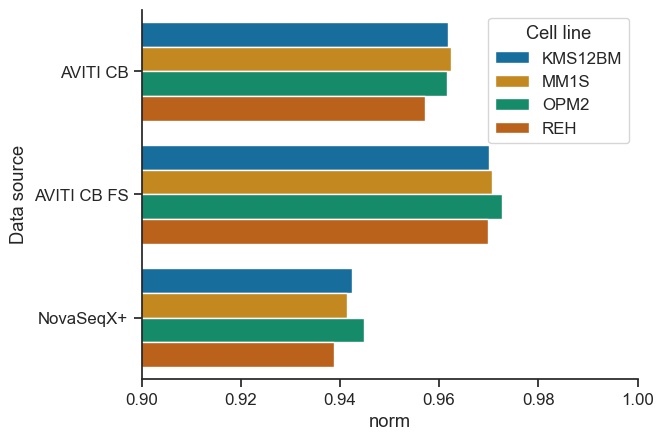

In [11]:
d = bq.copy()
bins = [-1,2,17,29,46]
labels = [0, 12, 24, 40]
d["qbin"] = pd.cut(d["quals"], bins=bins, labels=labels)
d = d.groupby(["Data source", "Cell line", "qbin"],as_index=False).agg({"bases":"sum", "norm": "sum"})
d["cumula"] = d.groupby(["Data source", "Cell line"])["bases"].transform(lambda x: 1-(np.cumsum(x)/x.sum()))
ax = sns.barplot(d[d["qbin"] == 40], hue="Cell line", x="norm", y="Data source")
sns.move_legend(ax, bbox_to_anchor=(1,1), loc="best")
ax.set_xlim(0.9,1)

<Axes: xlabel='qbin', ylabel='norm'>

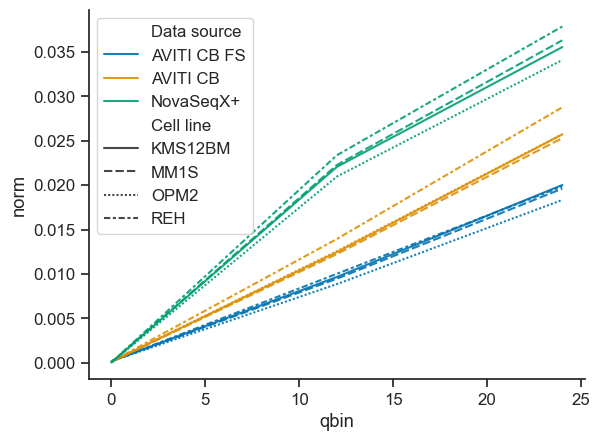

In [12]:
sns.lineplot(d[d["qbin"] != 40], x="qbin", y="norm", hue="Data source", style="Cell line",
                hue_order=run_names.values(), alpha=0.9)


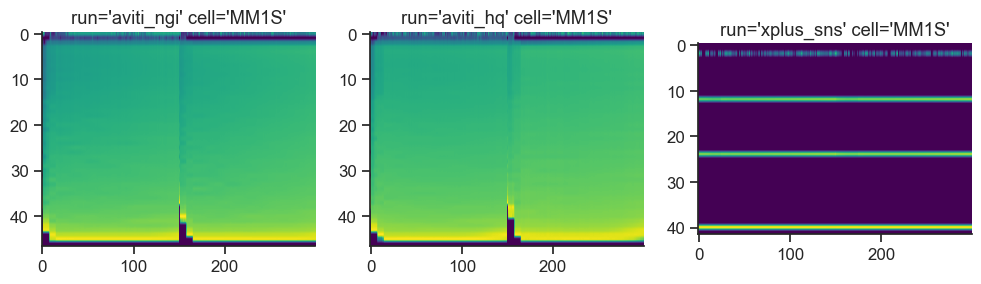

In [13]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,10))
files_mm1s = [(run, cell, file) for run, cell, file in files_md() if cell == "MM1S"]
for ax, (run, cell, file) in zip(axes.ravel(), files_mm1s):
    d1 = grep_file(file, "FFQ")
    d1 = d1.astype({c: int for c in d1.columns})
    d2 = grep_file(file, "LFQ")
    d2 = d2.astype({c: int for c in d2.columns})
    d2[0] += d1[0].max()
    d = pd.concat([d1,d2])
    quals = list(range(0,d.shape[1]-1))
    columns = ["cycle"] + quals
    d.columns = columns
    d[quals] += 1
    qualm = d[quals].T.apply(np.log10)
    
    ax.set_title(f"{run=} {cell=}")
    ax.imshow(qualm, aspect=5, cmap="viridis")
    


## Report BQ per cycle

In [14]:
bqc = [] 

for run, cell, file in files_md():
    d1 = grep_file(file, "FFQ")
    d1 = d1.astype({c: int for c in d1.columns})
    
    d2 = grep_file(file, "LFQ")
    d2 = d2.astype({c: int for c in d2.columns})
    d2[0] += d1[0].max()
    d = pd.concat([d1,d2])
    quals = list(range(0,d.shape[1]-1))
    print(run, cell, max(quals))

    columns = ["cycle"] + quals
    d.columns = columns
    d["Bases"] = d[quals].sum(axis=1)
    quals30 = [q for q in quals if q >= 30]
    d["BasesQ30+"] = d[quals30].sum(axis=1)
    d["Pct_ge_Q30"] = 100 * d["BasesQ30+"] / d["Bases"]
    d["run"] = run
    d["Cell line"] = cell
    bqc.append(d)

    
bqc = pd.concat(bqc).reset_index(drop=True)
bqc["Data source"] = bqc["run"].replace(run_names)
bqc

aviti_ngi KMS12BM 46
aviti_ngi MM1S 46
aviti_ngi OPM2 46
aviti_ngi REH 46
aviti_hq KMS12BM 46
aviti_hq MM1S 46
aviti_hq OPM2 46
aviti_hq REH 46
xplus_sns KMS12BM 41
xplus_sns MM1S 41
xplus_sns OPM2 41
xplus_sns REH 41


,cycle,0,1,2,3,4,5,6,7,8,...,43,44,45,46,Bases,BasesQ30+,Pct_ge_Q30,run,Cell line,Data source
0,1,396,0,0,2031,2573,3019,3863,2071,3724,...,0.0,0.0,0.0,0.0,190143015,189368149,99.592483,aviti_ngi,KMS12BM,AVITI CB FS
1,2,365148,0,7,1320,1726,1866,1278,1727,2219,...,117900865.0,0.0,0.0,0.0,190143015,189232622,99.521206,aviti_ngi,KMS12BM,AVITI CB FS
2,3,9708,0,3,1217,1683,1771,1277,1671,2138,...,116205204.0,0.0,0.0,0.0,190143015,189559130,99.692923,aviti_ngi,KMS12BM,AVITI CB FS
3,4,10,0,17,2112,2762,2941,2258,2694,3378,...,115004430.0,0.0,0.0,0.0,190143015,189424247,99.621986,aviti_ngi,KMS12BM,AVITI CB FS
4,5,8,0,115,4828,5981,6348,4998,5903,6697,...,114147033.0,0.0,0.0,0.0,190143015,188991633,99.394465,aviti_ngi,KMS12BM,AVITI CB FS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,296,0,0,4,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,640791311,561008568,87.549341,xplus_sns,REH,NovaSeqX+
3596,297,0,0,774,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,640791311,559287832,87.280808,xplus_sns,REH,NovaSeqX+
3597,298,0,0,2444,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,640791311,557988461,87.078032,xplus_sns,REH,NovaSeqX+
3598,299,0,0,8824,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,640791311,556943030,86.914885,xplus_sns,REH,NovaSeqX+


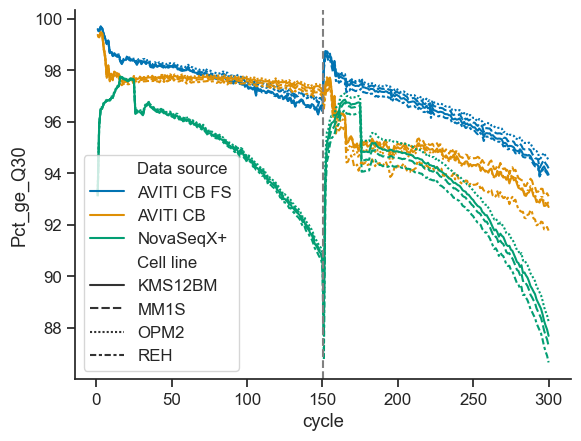

In [15]:
ax = sns.lineplot(bqc, x="cycle", y="Pct_ge_Q30", hue="Data source", style="Cell line", hue_order=run_names.values())
ax.axvline(x=150.5, color="grey", linestyle="--")

## Mapping quality

In [16]:
mapq = [] 
for run, cell, file in files_md():
    d = grep_file(file, "MAPQ")
    d = d.astype({c: int for c in d.columns})
    d.columns = ["MAPQ", "Reads"]
    
    print(run, cell, round(100 * float(d.query("MAPQ == 0")["Reads"] / d["Reads"].sum()), 1), int(d.query("MAPQ == 0")["Reads"]))
    # Ignore reads with MAPQ=0 as these could not be confidently placed
    d = d[d["MAPQ"] > 0]
    
    d["Relative reads"] = 100 * d["Reads"] / d["Reads"].sum()
    d = d[::-1]
    d["% Reads ge MAPQ"] = np.cumsum(d["Relative reads"])
    d["run"] = run
    d["Cell line"] = cell

    mapq.append(d)

mapq = pd.concat(mapq).reset_index(drop=True)
mapq["Data source"] = mapq["run"].replace(run_names)  
mapq.head()

aviti_ngi KMS12BM 4.0 14526879
aviti_ngi MM1S 4.2 15569086
aviti_ngi OPM2 4.1 17200209
aviti_ngi REH 4.1 12914279
aviti_hq KMS12BM 3.7 39834107
aviti_hq MM1S 3.9 40846650
aviti_hq OPM2 3.9 40232495
aviti_hq REH 3.9 36178970
xplus_sns KMS12BM 4.6 50046196
xplus_sns MM1S 4.9 51839183
xplus_sns OPM2 4.8 58247545
xplus_sns REH 4.9 47269122


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_69396/2092293556.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(run, cell, round(100 * float(d.query("MAPQ == 0")["Reads"] / d["Reads"].sum()), 1), int(d.query("MAPQ == 0")["Reads"]))
/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_69396/2092293556.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(run, cell, round(100 * float(d.query("MAPQ == 0")["Reads"] / d["Reads"].sum()), 1), int(d.query("MAPQ == 0")["Reads"]))
/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_69396/2092293556.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print(run, cell, round(100 * float(d.query("MAPQ == 0")["Reads"] / d["R

,MAPQ,Reads,Relative reads,% Reads ge MAPQ,run,Cell line,Data source
0,60,336633248,95.532179,95.532179,aviti_ngi,KMS12BM,AVITI CB FS
1,59,172658,0.048998,95.581177,aviti_ngi,KMS12BM,AVITI CB FS
2,58,51666,0.014662,95.595839,aviti_ngi,KMS12BM,AVITI CB FS
3,57,385855,0.109501,95.705340,aviti_ngi,KMS12BM,AVITI CB FS
4,56,63293,0.017962,95.723302,aviti_ngi,KMS12BM,AVITI CB FS


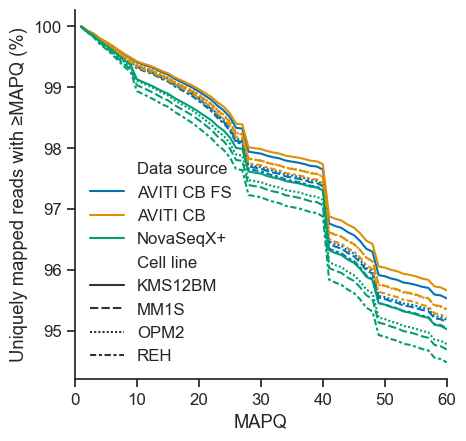

In [17]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax = sns.lineplot(mapq, x="MAPQ", y="% Reads ge MAPQ", hue="Data source", hue_order=run_names.values(), 
                  style="Cell line")
ax.set_ylabel("Uniquely mapped reads with ≥MAPQ (%)")
ax.set_xlim(0,60)
ax.legend(frameon=False, framealpha=0)

fig.savefig(figdir / "mapq_cumulartive_read_density.svg", backend='svg', transparent=True, dpi=300, bbox_inches='tight')


# Summary numbers


In [18]:
sn = [] 

for run, cell, file in files_md():
    d = grep_file(file, "SN")
    d.columns = ["Stat", "Value", "Extra"]
    d["Stat"] = d["Stat"].str[:-1]
    d["Value"] = d["Value"].astype(float)
    d = d.drop(columns="Extra")
    d = d.set_index("Stat").T
    #d = d.astype({c: int for c in d.columns})
    d["run"] = run
    d["Cell line"] = cell
    sn.append(d)
    
sn = pd.concat(sn).reset_index(drop=True)
sn["Data source"] = sn["run"].replace(run_names)
sn["Data source"] = sn["Data source"].astype("category")
sn["Data source"] = sn["Data source"].cat.reorder_categories(run_names.values(), ordered=True)

#sn = sn.set_index(["Data source", "Cell line"])

sn["% mapped"] = 100 * sn["reads mapped"] / sn["sequences"]
sn["% unmapped"] = 100 * sn["reads unmapped"] / sn["sequences"]
sn["% duplicates"] = 100 * sn["reads duplicated"] / sn["sequences"]
sn["% MAPQ=0"] = 100 * sn["reads MQ0"] / sn["sequences"]
sn.describe()

Stat,raw total sequences,filtered sequences,sequences,is sorted,1st fragments,last fragments,reads mapped,reads mapped and paired,reads unmapped,reads properly paired,...,insert size standard deviation,inward oriented pairs,outward oriented pairs,pairs with other orientation,pairs on different chromosomes,percentage of properly paired reads (%),% mapped,% unmapped,% duplicates,% MAPQ=0
count,1.200000e+01,12.0,1.200000e+01,12.0,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,...,12.000000,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000
mean,9.391212e+08,0.0,9.391212e+08,1.0,4.695606e+08,4.695606e+08,9.371604e+08,9.361459e+08,1.960737e+06,9.221624e+08,...,92.875000,4.604014e+08,2.365038e+06,5.739655e+05,4.732517e+06,98.308333,99.813686,0.186314,9.057511,4.079422
std,4.484429e+08,0.0,4.484429e+08,0.0,2.242215e+08,2.242215e+08,4.470593e+08,4.465753e+08,1.549139e+06,4.384126e+08,...,3.151947,2.188329e+08,1.179039e+06,3.468624e+05,3.296666e+06,0.372847,0.073780,0.073780,10.031717,0.155711
min,3.264107e+08,0.0,3.264107e+08,1.0,1.632054e+08,1.632054e+08,3.258778e+08,3.254533e+08,5.329570e+05,3.209633e+08,...,87.900000,1.602809e+08,8.348480e+05,1.370160e+05,1.383854e+06,97.600000,99.691424,0.120298,0.985091,3.802169
25%,4.190171e+08,0.0,4.190171e+08,1.0,2.095085e+08,2.095085e+08,4.184787e+08,4.180489e+08,5.448112e+05,4.132649e+08,...,90.675000,2.062491e+08,1.134522e+06,2.255738e+05,1.537486e+06,98.050000,99.733830,0.133572,1.322981,3.970176
50%,1.051554e+09,0.0,1.051554e+09,1.0,5.257768e+08,5.257768e+08,1.050227e+09,1.049204e+09,1.355872e+06,1.036739e+09,...,93.100000,5.178517e+08,2.385492e+06,5.707865e+05,3.847417e+06,98.450000,99.857446,0.142554,3.510211,4.096682
75%,1.304821e+09,0.0,1.304821e+09,1.0,6.524103e+08,6.524103e+08,1.301127e+09,1.299597e+09,3.643610e+06,1.273704e+09,...,94.850000,6.357714e+08,3.487545e+06,7.877865e+05,8.471792e+06,98.600000,99.866428,0.266170,21.541939,4.171415
max,1.573794e+09,0.0,1.573794e+09,1.0,7.868971e+08,7.868971e+08,1.569468e+09,1.567833e+09,4.325730e+06,1.543348e+09,...,97.800000,7.703548e+08,4.131056e+06,1.101128e+06,9.488510e+06,98.700000,99.879702,0.308576,23.939115,4.333681


In [19]:
sn["M_read_pairs"] = sn["raw total sequences"] / 2 / 1e6
sn[["Data source", "Cell line", "M_read_pairs", "insert size average","% mapped", "percentage of properly paired reads (%)", "% MAPQ=0", "reads MQ0"]]

Stat,Data source,Cell line,M_read_pairs,insert size average,% mapped,percentage of properly paired reads (%),% MAPQ=0,reads MQ0
0,AVITI CB FS,KMS12BM,190.143015,392.1,99.856418,98.6,3.919210,14904207.0
1,AVITI CB FS,MM1S,191.194703,397.4,99.858474,98.5,4.256507,16276432.0
2,AVITI CB FS,OPM2,215.613158,387.2,99.875375,98.7,4.143589,17868248.0
3,AVITI CB FS,REH,163.205364,410.3,99.836722,98.3,4.063643,13264168.0
4,AVITI CB,KMS12BM,538.849263,405.9,99.865890,98.6,3.802169,40975923.0
5,AVITI CB,MM1S,525.335834,411.1,99.868043,98.5,4.129720,43389797.0
6,AVITI CB,OPM2,526.217748,400.0,99.879702,98.7,4.013837,42243050.0
7,AVITI CB,REH,474.806283,425.4,99.860437,98.4,3.931563,37334619.0
8,NovaSeqX+,KMS12BM,694.405771,405.8,99.691424,97.9,3.983047,55317020.0
9,NovaSeqX+,MM1S,687.267463,411.8,99.736727,97.8,4.333681,59567955.0


In [20]:
sn.style

Stat,raw total sequences,filtered sequences,sequences,is sorted,1st fragments,last fragments,reads mapped,reads mapped and paired,reads unmapped,reads properly paired,reads paired,reads duplicated,reads MQ0,reads QC failed,non-primary alignments,supplementary alignments,total length,total first fragment length,total last fragment length,bases mapped,bases mapped (cigar),bases trimmed,bases duplicated,mismatches,error rate,average length,average first fragment length,average last fragment length,maximum length,maximum first fragment length,maximum last fragment length,average quality,insert size average,insert size standard deviation,inward oriented pairs,outward oriented pairs,pairs with other orientation,pairs on different chromosomes,percentage of properly paired reads (%),run,Cell line,Data source,% mapped,% unmapped,% duplicates,% MAPQ=0,M_read_pairs
0,380286030.000000,0.000000,380286030.000000,1.000000,190143015.000000,190143015.000000,379740009.000000,379310530.000000,546021.000000,374937982.000000,380286030.000000,12836317.000000,14904207.000000,0.000000,0.000000,1401922.000000,57042904500.000000,28521452250.000000,28521452250.000000,56961001350.000000,56789018800.000000,0.000000,1925447550.000000,217962802.000000,0.003838,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,43.100000,392.100000,89.400000,187124500.000000,1006059.000000,137016.000000,1387690.000000,98.600000,aviti_ngi,KMS12BM,AVITI CB FS,99.856418,0.143582,3.375437,3.919210,190.143015
1,382389406.000000,0.000000,382389406.000000,1.000000,191194703.000000,191194703.000000,381848224.000000,381421500.000000,541182.000000,376503962.000000,382389406.000000,14214775.000000,16276432.000000,0.000000,0.000000,1600308.000000,57358410900.000000,28679205450.000000,28679205450.000000,57277233600.000000,57090312830.000000,0.000000,2132216250.000000,241424219.000000,0.004229,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,43.100000,397.400000,92.600000,187863794.000000,1038504.000000,221034.000000,1587418.000000,98.500000,aviti_ngi,MM1S,AVITI CB FS,99.858474,0.141526,3.717356,4.256507,191.194703
2,431226316.000000,0.000000,431226316.000000,1.000000,215613158.000000,215613158.000000,430688901.000000,430258054.000000,537415.000000,425518570.000000,431226316.000000,15718136.000000,17868248.000000,0.000000,0.000000,1454790.000000,64683947400.000000,32341973700.000000,32341973700.000000,64603335150.000000,64412889603.000000,0.000000,2357720400.000000,241500221.000000,0.003749,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,43.200000,387.200000,87.900000,212377511.000000,1166528.000000,200227.000000,1384761.000000,98.700000,aviti_ngi,OPM2,AVITI CB FS,99.875375,0.124625,3.644985,4.143589,215.613158
3,326410728.000000,0.000000,326410728.000000,1.000000,163205364.000000,163205364.000000,325877771.000000,325453324.000000,532957.000000,320963316.000000,326410728.000000,10324473.000000,13264168.000000,0.000000,0.000000,1306021.000000,48961609200.000000,24480804600.000000,24480804600.000000,48881665650.000000,48720272558.000000,0.000000,1548670950.000000,207197664.000000,0.004253,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,43.100000,410.300000,93.600000,160280873.000000,834848.000000,227087.000000,1383854.000000,98.300000,aviti_ngi,REH,AVITI CB FS,99.836722,0.163278,3.163031,4.063643,163.205364
4,1077698526.000000,0.000000,1077698526.000000,1.000000,538849263.000000,538849263.000000,1076253220.000000,1075163312.000000,1445306.000000,1062705876.000000,1077698526.000000,10616316.000000,40975923.000000,0.000000,0.000000,3943904.000000,161654778900.000000,80827389450.000000,80827389450.000000,161437983000.000000,160985094774.000000,0.000000,1592447400.000000,722657638.000000,0.004489,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,42.600000,405.900000,91.100000,530860284.000000,2415598.000000,459834.000000,3845940.000000,98.600000,aviti_hq,KMS12BM,AVITI CB,99.865890,0.134110,0.985091,3.802169,538.